# Two Asset HANK Model [<cite data-cite="6202365/ECL3ZAR7"></cite>](https://cepr.org/active/publications/discussion_papers/dp.php?dpno=13071)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/HARK/BayerLuetticke/notebooks?filepath=HARK%2FBayerLuetticke%2FTwoAsset.ipynb)

- Adapted from original slides by Christian Bayer and Ralph Luetticke (Henceforth, 'BL')
- Jupyter notebook originally by Seungcheol Lee
- Further edits by Chris Carroll, Tao Wang, Edmund Crawley

### Overview

BL propose a method for solving Heterogeneous Agent DSGE models that uses fast tools originally employed for image and video compression to speed up a variant of the solution methods proposed by Michael Reiter. <cite data-cite="undefined"></cite>

The Bayer-Luetticke method has the following broad features:
   * The model is formulated and solved in discrete time (in contrast with some other recent approaches <cite data-cite="6202365/WN76AW6Q"></cite>)
   * Solution begins by calculation of the steady-state equilibrium (StE) with no aggregate shocks
   * Both the representation of the consumer's problem and the desciption of the distribution are subjected to a form of ["dimensionality reduction"](https://en.wikipedia.org/wiki/Dimensionality_reduction)
      * This means finding a way to represent these objects efficiently using fewer points
   * "Dimensionality reduction" of the consumer's decision problem is performed before any further analysis is done
      * This involves finding a representation of the policy functions using some class of ["basis functions"](https://en.wikipedia.org/wiki/Basis_function)
   * Dimensionality reduction of the joint distribution is accomplished using a ["copula"](https://en.wikipedia.org/wiki/Copula_(probability_theory))
      * See the companion notebook "DCT-Copula-Illustration" for a detailed description of the copula
   * The method approximates the business-cycle-induced _deviations_ of the individual policy functions from those that characterize the riskless StE
      * This is done using the same basis functions originally optimized to match the StE individual (micro) policy function
      * The method of capturing dynamic deviations from a reference frame is akin to video compression

### Setup

#### The Recursive Dynamic Planning Problem

BL describe their problem a generic way; here, we will illustrate the meaning of their derivations and notation using the familiar example of the Krusell-Smith model, henceforth KS.  <cite data-cite="6202365/VPUXICUR"></cite>

Consider a household problem in presence of aggregate and idiosyncratic risk
   * $S_t$ measures the (exogenous) aggregate state (e.g., levels of productivity and unemployment)
   * $s_{it}$ records agent $i$'s idiosyncratic state (exogenous and endogenous, e.g. employment or assets)
   * $\mu_t$ is the distribution over $s$ at date $t$ (e.g., the wealth distribution)
   * $P_{t}$ is the pricing kernel
      * It captures the info about the aggregate state that the consumer needs to know in order to behave optimally
      * e.g., KS showed that for their problem, a good _approximation_ to $P_{t}$ could be constructed
        using only the economy's 'good/bad' state and the aggregate capital stock $K_{t}$
   * $\Gamma$ defines the budget set
      * This delimits the set of feasible choices $x$ that the agent can make

The Bellman equation is:

\begin{equation}
        v(s_{it},S_t,\mu_t) = \max\limits_{x \in \Gamma(s_{it},P_t)} u(s_{it},x) + \beta \mathbb{E}_{t} v(s_{it+1}(x,s_{it}),S_{t+1},\mu_{t+1})
\end{equation}

which, for many types of problems, implies a corresponding Euler equation: <!-- Question: Why isn't R a t+1 dated variable (and inside the expectations operator? -->
     \begin{equation}
        u^{\prime}\left(s_{it},x(s_{it},S_t,\mu_t)\right) = \beta \mathbb{E}_{t} R(S_t,S_{t+1},\mu_t,\mu_{t+1}) u^{\prime}\left(s_{it+1},x(s_{it+1},S_{t+1},\mu_{t+1})\right)
     \end{equation}


#### Solving for the StE

The steady-state equilibrium is the one that will come about if there are no aggregate risks (and consumers know this)

The first step in solving the full model is to solve for the steady-state:
   * Discretize the state space
      * Representing the nodes of the discretization in a set of vectors
      * Such vectors will be represented by an overbar
      * For example, the vectors $\bar{s}_{it}$ and $\bar{c}_{it}$ define a set of points on the policy function (the consumption function)
   * The optimal policy $\newcommand{\policy}{c}\newcommand{\Policy}{C}\policy(s_{it};P(\mu))$ induces flow utility $u_{\policy}$ whose discretization is a vector $\bar{u}_{\bar{\policy}}$
   * Idiosyncratic dynamics are captured by a transition probability matrix $\Pi_{\bar{\policy}}$
       * $\Pi$ is like an expectations operator
           * Given the consumer's state in $t$ it measures the probability of being in any other state in period $t+1$
       * It depends on the vectorization of the policy function $\bar{\policy}$
   * $P$ is constant because in StE aggregate prices are constant
       * e.g., in the KS problem, $P$ would contain the (constant) wage and interest rates
   * In StE, the discretized Bellman equation that if $\bar{v}$ measures value at the discretized nodes,
     \begin{equation}
        \bar{v} = \bar{u} + \beta \Pi_{\bar{\policy}}\bar{v}
      \end{equation}
     holds for the optimal policy
   * For the distribution $\mu$ of consumers across states, which (by the definition of steady state) is constant:
\begin{eqnarray}
        \bar{\mu} & = & \bar{\mu} \Pi_{\bar{\policy}} \\
             d\bar{\mu} & = & d\bar{\mu} \Pi_{\bar{\policy}}
\end{eqnarray}<!--     where we differentiate in the second line because we will be representing the distribution as a histogram, which counts the _extra_ population obtained by moving up --> <!-- Is this right?  $\mu$ vs $d \mu$ is a bit confusing.  The d is wrt the state, not time, right? -->

We will define an approximate equilibrium in which:
   * $\bar{\policy}$ is the vector that defines a linear interpolating policy function $\policy$ at the state nodes
       * given $P$ and $v$
       * $v$ is a linear interpolation of $\bar{v}$
   * $\bar{v}$ and $d\bar{\mu}$ solve the approximated Bellman equation
       * subject to the steady-state constraint
   * Markets clear ($\exists$ joint requirement on $\bar{\policy}$, $\mu$, and $P$; denoted as $\Phi(\bar{\policy}, \mu, P) = 0$)  <!-- Question: Why is this not $\bar{\mu}$ -->

This can be solved by:
   1. Given $P$,
       1. Finding $d\bar{\mu}$ as the unit-eigenvalue of $\Pi_{\bar{\policy}}$
       2. Using standard solution techniques to solve the micro decision problem
          * Given, e.g., that the aggregate wage and interest rate are constant
   2. Using a root-finder to solve for $P$
      * This basically iterates the other two steps until it finds values where they are consistent

####  Introducing aggregate risk

With aggregate risk
   * Prices $P$ and the distribution $\mu$ change over time

Yet, for the household:
   * Only prices and continuation values matter
   * The distribution does not influence decisions directly

#### Sequential Equilibrium (Reiter, 2002)
A 'sequential equilibrium with recursive individual planning'  <cite data-cite="6202365/UKUXJHCN"></cite> is:
   * A sequence of discretized Bellman equations, such that
     \begin{equation}
        v_t = \bar{u}_{P_t} + \beta \Pi_{\policy_t} v_{t+1}
     \end{equation}
     holds for policy $\policy_t$ which optimizes with respect to $v_{t+1}$ and $P_t$
   * and a sequence of "histograms" $d \mu$ (discretized distributions), such that
     \begin{equation}
        d\mu_{t+1} = d\mu_t \Pi_{\policy_t}
     \end{equation}
     holds given the policy $h_{t}$, that is optimal given $P_t$, $v_{t+1}$
     * That is, given a histogram describing the distribution in period $t$, $d \mu_{t}$, next period's histogram is determined by the transition matrix
   * Prices, distribution, and policies lead to market clearing

#### Compact notation

It will be convenient to rewrite the problem using a compact notation proposed by Schmidt-Grohe and Uribe (2004)

The equilibrium conditions can be represented as a non-linear difference equation
   * Controls: $Y_t = [v_t \ P_t \ Z_t^Y]$ and States: $X_t=[\mu_t \ S_t \ Z_t^X]$
      * where $Z_t$ are purely aggregate states/controls
   * Define <!-- Q: What is $\epsilon$ here? Why is it not encompassed in S_{t+1}? -->
     \begin{align}
      F(d\mu_t, S_t, d\mu_{t+1}, S_{t+1}, v_t, P_t, v_{t+1}, P_{t+1}, \epsilon_{t+1})
      &= \begin{bmatrix}
           d\mu_{t+1} - d\mu_t\Pi_{\policy_t} \\
           v_t - (\bar{u}_{\policy_t} + \beta \Pi_{\policy_t}v_{t+1}) \\
           S_{t+1} - \Policy(S_t,d\mu_t,\epsilon_{t+1}) \\
           \Phi(\policy_t,d\mu_t,P_t,S_t) \\
           \epsilon_{t+1}
           \end{bmatrix}
     \end{align}
     s.t. <!-- Q: Why are S_{t+1} and \epsilon_{t+1} not arguments of v_{t+1} below? -->
     \begin{equation}
     \policy_t(s_{t}) = \arg \max\limits_{x \in \Gamma(s,P_t)} u(s,x) + \beta \mathop{\mathbb{E}_{t}} v_{t+1}(s_{t+1})
     \end{equation}
   * The solution is a function-valued difference equation:
\begin{equation}
     \mathop{\mathbb{E}_{t}}F(X_t,X_{t+1},Y_t,Y_{t+1},\epsilon_{t+1}) = 0
\end{equation}
     where $\mathop{\mathbb{E}}$ is the expectation over aggregate states
   * It becomes real-valued when we replace the functions by their discretized counterparts
   * Standard techniques can solve the discretized version

#### So, is all solved?
The dimensionality of the system F is a big problem
   * With high dimensional idiosyncratic states, discretized value functions and distributions become large objects
   * For example:
      * 4 income states $\times$ 100 illiquid capital states $\times$ 100 liquid capital states $\rightarrow$ $\geq$ 40,000 values in $F$

### Bayer-Luetticke method
#### Idea:
1. Use compression techniques as in video encoding
   * Apply a [discrete cosine transformation](https://en.wikipedia.org/wiki/Discrete_cosine_transform) (DCT) to all value/policy functions
      * DCT is used because it is the default in the video encoding literature
      * Choice of cosine is unimportant
         * linear basis functions might work just as well
      * This lets us represent the functions with many fewer points
   * Fluctuations are represented as differences from this reference frame
   * Assume all coefficients of the DCT from the StE that are close to zero do not change when there is an aggregate shock (small things stay small)

2. Assume no changes in the rank correlation structure of $\mu$
   * $\Rightarrow d\mu $ can be represented by a Copula
   * Calculate the Copula, $\bar{C}$ of $\mu$ in the StE
   * Perturb only the marginal distributions
      * This assumes that the rank correlations remain the same
      * See the companion notebook for more discussion of this
   * Use fixed Copula to calculate an approximate joint distribution from marginals


The approach follows the insight of KS in that it uses the fact that some moments of the distribution do not matter for aggregate dynamics

#### Details
1) Compression techniques from video encoding
   * Let $\bar{\Theta} = dct(\bar{v})$ be the coefficients obtained from the DCT of the value function in StE
   * Define an index set $\mathop{I}$ that contains the x percent largest (i.e. most important) elements from $\bar{\Theta}$
   * Let $\theta$ be a sparse vector with non-zero entries only for elements $i \in \mathop{I}$
   * Define
   \begin{equation}
    \tilde{\Theta}(\theta_t)=\left\{
      \begin{array}{@{}ll@{}}
         \bar{\Theta}(i)+\theta_t(i), & i \in \mathop{I} \\
              \bar{\Theta}(i), & \text{else}
      \end{array}\right.
   \end{equation}
   * This assumes that the basis functions with least contribution to representation of the function in levels, make no contribution at all to its changes over time

2) Decoding
   * Now we reconstruct $\tilde{v}(\theta_t)=dct^{-1}(\tilde{\Theta}(\theta_{t}))$
      * idct=$dct^{-1}$ is the inverse dct that goes from the $\theta$ vector to the corresponding values
   * This means that in the StE the reduction step adds no addtional approximation error:
       * Remember that $\tilde{v}(0)=\bar{v}$ by construction
   * But it allows us to reduce the number of derivatives that need to be calculated from the outset.
       * We only calculate derivatives for those basis functions that make an important contribution to the representation of the function

3) The histogram is recovered as follows
   * $\mu_t$ is approximated as $\bar{C}(\bar{\mu_t}^1,...,\bar{\mu_t}^n)$, where $n$ is the dimensionality of the idiosyncratic states <!-- Question: Why is there no time subscript on $\bar{C}$?  I thought the copula was allowed to vary over time ... --> <!-- Question: is $\mu_{t}$ linearly interpolated between gridpoints? ... -->
      * $\mu_t^{i}$ are the marginal distributions <!-- Question: These are cumulatives, right?  They are not in the same units as $\mu$ -->
   * The StE distribution is obtained when $\mu = \bar{C}(\bar{\mu}^1,...,\bar{\mu}^n)$
   * Typically prices are only influenced through the marginal distributions
   * The approach ensures that changes in the mass of one state (say, wealth) are distributed in a sensible way across the other dimensions
      * Where "sensible" means "like in StE" <!-- Question: Right? -->
   * The implied distributions look "similar" to the StE one (different in (Reiter, 2009))

4) The large system above is now transformed into a much smaller system:
     \begin{align}
      F(\{d\mu_t^1,...,d\mu_t^n\}, S_t, \{d\mu_{t+1}^1,...,d\mu_{t+1}^n\}, S_{t+1}, \theta_t, P_t, \theta_{t+1}, P_{t+1})
      &= \begin{bmatrix}
           d\bar{C}(\bar{\mu}_t^1,...,\bar{\mu}_t^n) - d\bar{C}(\bar{\mu}_t^1,...,\bar{\mu}_t^n)\Pi_{\policy_t} \\
                dct\left[idct\left(\tilde{\Theta}(\theta_t) - (\bar{u}_{\policy_t} + \beta \Pi_{\policy_t}idct(\tilde{\Theta}(\theta_{t+1}))\right)\right] \\
                S_{t+1} - \Policy(S_t,d\mu_t) \\
                \Phi(\policy_t,d\mu_t,P_t,S_t) \\
                \end{bmatrix}
     \end{align}


### The two-asset HANK model

We illustrate the algorithm in a two-asset HANK model described as below


#### Households
- Maximizing discounted felicity
   - Consumption $c$ 
      - CRRA coefficent: $\xi$
      - EOS of CES consumption bundle: $\eta$
   - Disutility from work in GHH form: 
     - Frisch elasticity $\gamma$
- Two assets:
   - Liquid nominal bonds $b$, greater than lower bound $\underline b$
      - Borrowing constraint due to a wedge between borrowing and saving rate:  $R^b(b<0)=R^B(b>0)+\bar R$  
   - Illiquid assets capital $k$ nonnegative
      - Trading of illiquid assets is subject to a friction governed by $v$, the fraction of agents who can trade
      - If nontrading, receive dividend $r$ and depreciates by $\tau$
- Idiosyncratic labor productivity $h$: 
   - $h = 0$ for entreprener, only receive profits $\Pi$
   - $h = 1$ for labor, evolves according to an autoregressive process, 
     - $\rho_h$ persistence parameter
     - $\epsilon^h$: idiosyncratic risk 

#### Production 
- Intermediate good producer 
    - CRS production with TFP $Z$
    - Wage $W$
    - Cost of capital $r+\delta$
- Reseller 
    - Rotemberg price setting: quadratic adjustment cost scalled by $\frac{\eta}{2\kappa}$
    - Constant discount factor $\beta$
    - Investment subject to Tobin's q adjustment cost $\phi$ 
- Aggregate risks $\Omega$ include 
   - TFP $Z$, AR(1) process with persistence of $\rho^Z$ and shock $\epsilon^Z$  
   - Uncertainty 
   - Monetary policy
- Central bank
   - Taylor rule on nominal saving rate $R^B$: reacts to deviation of inflation from target by $\theta_R$ 
   - $\rho_R$: policy inertia
   - $\epsilon^R$: monetary policy shocks
- Government (fiscal rule)
   - Government spending $G$ 
   - Tax $T$ 
   - $\rho_G$: intensity of repaying government debt: $\rho_G=1$ implies roll-over 

#### Taking stock

- Individual state variables: $\newcommand{\liquid}{m}\liquid$, $k$ and $h$, the joint distribution of individual states $\Theta$
- Individual control variables: $c$, $n$, $\liquid'$, $k'$ 
- Optimal policy for adjusters and nonadjusters are $c^*_a$, $n^*_a$ $k^*_a$ and $\liquid^*_a$ and  $c^*_n$, $n^*_n$ and $\liquid^*_n$, respectively 


In [1]:
# Setup stuff 


# The tools for navigating the filesystem
import sys
import os
import pickle
import time
import warnings
from copy import copy
# Ignore scary but unimportant system warnings while running the notebook
warnings.filterwarnings('ignore')
from IPython import get_ipython

SGU_solver
Elapsed time is  1.5755370439999998  seconds.
Use Schmitt Grohe Uribe Algorithm
 A *E[xprime uprime] =B*[x u]
 A = (dF/dxprimek dF/duprime), B =-(dF/dx dF/du)
Computing Jacobian F1=DF/DXprime F3 =DF/DX
Total number of parallel blocks:  21 .
Block number:  0
Block number:  1
Block number:  2
Block number:  3
Block number:  4
Block number:  5
Block number:  6
Block number:  7
Block number:  8
Block number:  9
Block number:  10
Block number:  11
Block number:  12
Block number:  13
Block number:  14
Block number:  15
Block number:  16
Block number:  17
Block number:  18
Block number:  19
Block number:  20
bl order
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Elapsed time is  53.139570502  seconds.
Computing Jacobian F2 - DF/DYprime
Total number of parallel blocks:  24 .
Block number:  0
Block number:  1
Block number:  2
Block number:  3
Block number:  4
Block number:  5
Block number:  6
Block number:  7
Block number:  8
Block number:  9
Block number

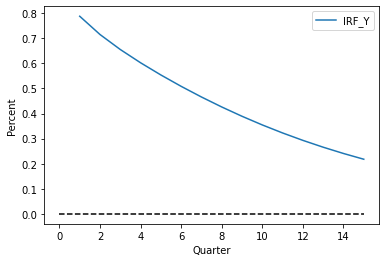

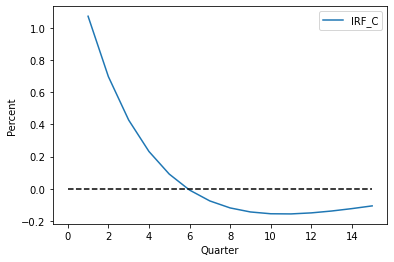

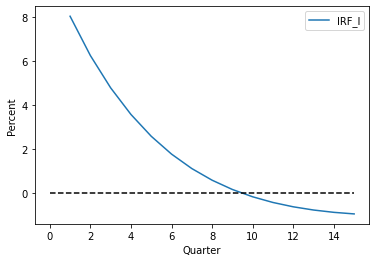

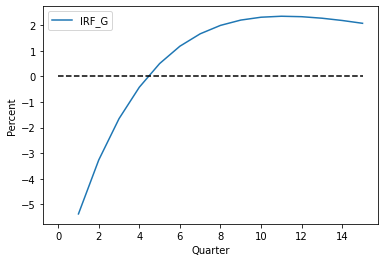

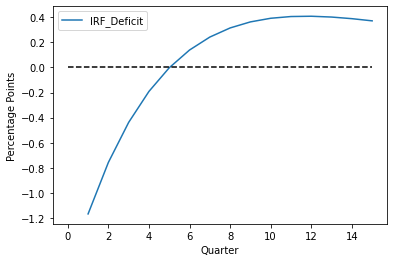

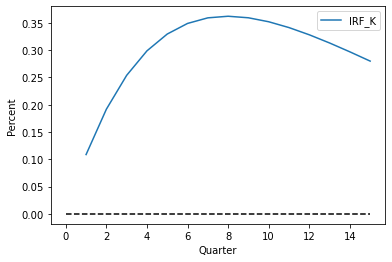

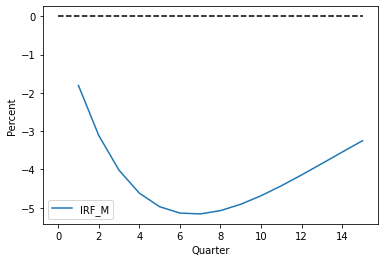

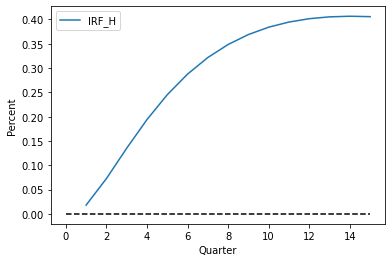

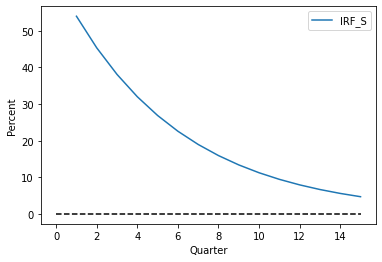

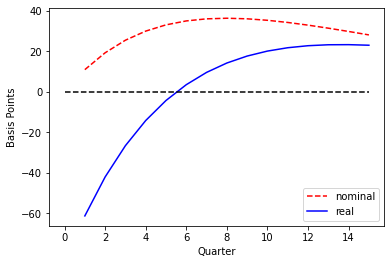

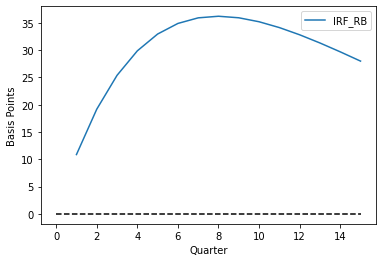

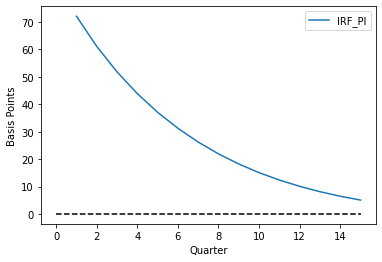

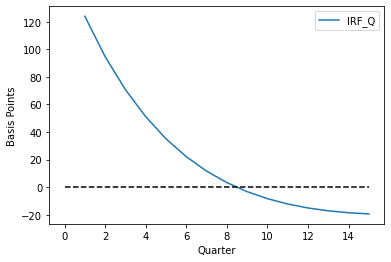

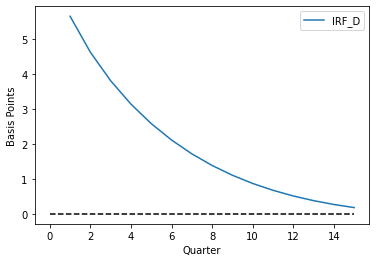

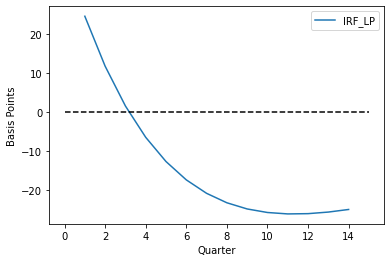

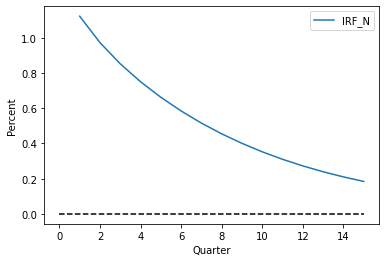

In [2]:
# Code must be inside a main() block to be usable for multiprocessing from command line
# Jupyter notebooks ignore the multiprocessing (so are slower)
def main():

    # Find pathname to this file:

    # This is a jupytext paired notebook that autogenerates a corresponding .py file
    # which can be executed from a terminal command line via "ipython [name].py"
    # But a terminal does not permit inline figures, so we need to test jupyter vs terminal
    # Google "how can I check if code is executed in the ipython notebook"
    
    def in_ipynb():
        try:
            if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
                return True
            else:
                return False
        except NameError:
            return False
    
    # Determine whether to make the figures inline (for spyder or jupyter)
    # vs whatever is the automatic setting that will apply if run from the terminal
    if in_ipynb():
        # matplotlib inline generates a syntax error when run from the shell
        # so do this instead
        get_ipython().run_line_magic('matplotlib', 'inline') 
    else:
        from matplotlib.pyplot import ion
        ion()
        get_ipython().run_line_magic('matplotlib', 'auto') 

    my_file_path = os.path.dirname(os.path.abspath("TwoAsset-HANK.py"))
    
    # Relative and absolute paths for pickled code
    code_dir_rel = os.path.join(my_file_path, "../Assets/Two") 
    code_dir = os.path.abspath(code_dir_rel)
    
    sys.path.insert(0, code_dir)
    sys.path.insert(0, my_file_path)
    
    ## Load precomputed Stationary Equilibrium (StE) object EX3SS_20
    
    os.chdir(code_dir) # Go to the directory with pickled code
    
    ## EX3SS_20.p is the information in the stationary equilibrium 
    ## (20: the number of illiquid and liquid weath gridpoints )
    EX3SS=pickle.load(open("EX3SS_20.p", "rb"))

    from FluctuationsTwoAsset import FluctuationsTwoAsset, SGU_solver, plot_IRF
    
    start_time = time.perf_counter() 
    
    ## Choose one of three aggregate shocks to perturb
    ## MP (monetary policy)
    ## TFP (total factor productivity)
    ## Uncertainty
    
    # EX3SS['par']['aggrshock']           = 'MP'
    # EX3SS['par']['rhoS']    = 0.0      # Persistence of variance
    # EX3SS['par']['sigmaS']  = 0.001    # STD of variance shocks
    
    # EX3SS['par']['aggrshock']           = 'TFP'
    # EX3SS['par']['rhoS']    = 0.95
    # EX3SS['par']['sigmaS']  = 0.0075
        
    EX3SS['par']['aggrshock'] = 'Uncertainty'
    EX3SS['par']['rhoS'] = 0.84      # Persistence of variance
    EX3SS['par']['sigmaS'] = 0.54    # STD of variance shocks
    
    ## Choose an accuracy of approximation with DCT
    ### Determines number of basis functions chosen -- enough to match this accuracy
    ### EX3SS is precomputed steady-state pulled in above
    EX3SS['par']['accuracy'] = 0.99999 
    
    ## Implement state reduction and DCT
    ### Do state reduction on steady state
    
    EX3SR = FluctuationsTwoAsset(**EX3SS)
    SR = EX3SR.StateReduc()
    
    print('SGU_solver')
    SGUresult = SGU_solver(SR['Xss'],SR['Yss'],SR['Gamma_state'],SR['indexMUdct'],SR['indexVKdct'],SR['par'],SR['mpar'],SR['grid'],SR['targets'],SR['Copula'],SR['P_H'],SR['aggrshock'])
    print('plot_IRF')
    plot_IRF(SR['mpar'],SR['par'],SGUresult['gx'],SGUresult['hx'],SR['joint_distr'],
             SR['Gamma_state'],SR['grid'],SR['targets'],SR['Output'])
    
    end_time = time.perf_counter()
    print('Elapsed time is ',  (end_time-start_time), ' seconds.')

if __name__ == "__main__":
    main()